In [2]:
from utils.dawnfrb import FRBInfo
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
catalog = FRBInfo(
    '/home/jovyan/work/chime_data/21.0007/',
    '/home/jovyan/work/chime_data/23.0004/',
    remove_duplicates=True
)

In [3]:
filenames = glob.glob('/home/jovyan/work/chime_data/calibrated_wfalls/*.npz')

In [4]:
catalog.catalog['plot_time']=catalog['plot_time']

In [5]:
np.unique([np.median(np.diff(t)) for t in catalog['plot_time']])

array([0.98303985, 0.98303996, 0.98303999, 0.98304   , 0.98304   ,
       0.98304   , 0.98304001, 0.98304002, 0.98304008, 0.98304031])

In [4]:
def bin_freq_channels(data, fbin_factor=4):
    num_chan = data.shape[0]
    if num_chan % fbin_factor != 0:
        raise ValueError("frequency binning factor `fbin_factor` should be even")
    data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)
    return data

In [5]:
padded_wfalls=[]
for f in tqdm(filenames):
    cal_wfall = np.load(f)['cal_wfall']
    cal_wfall[np.isnan(cal_wfall)] = np.nanmedian(cal_wfall)
    cal_wfall = bin_freq_channels(cal_wfall,64)
    a=np.argmax(np.mean(cal_wfall,axis=0))
    m=np.median(cal_wfall)
    p=np.array([np.pad(cc,(2017-a,2047-(cal_wfall.shape[1]-a)),'constant',constant_values=m) for cc in cal_wfall])
    padded_wfalls.append(p[:,2017-25:2017+25])

100%|██████████| 583/583 [04:37<00:00,  2.10it/s]


In [33]:
import pickle
with open('data/cal_wfalls_binned.p','wb') as f:
    pickle.dump(cal_wfalls,f)

In [1]:
import pickle
cal_wfalls=pickle.load(open('data/cal_wfalls_binned.p','rb'))

In [4]:
before=[]
after=[]
for c in cal_wfalls:
    a=np.argmax(np.mean(c,axis=0))
    before.append(a)
    after.append(c.shape[1]-a)
print(max(before))
print(max(after))

2017
2047


In [10]:
padded_wfalls=[]
for c in cal_wfalls:
    a=np.argmax(np.mean(c,axis=0))
    m=np.median(c)
    p=np.array([np.pad(cc,(max(before)-a,max(after)-(c.shape[1]-a)),'constant',constant_values=m) for cc in c])
    padded_wfalls.append(p[:,2017-25:2017+25])

In [9]:
import pickle
with open('data/cal_wfalls_binned_aligned_padded_truncated_50ms.p','wb') as f:
    pickle.dump(padded_wfalls,f)

In [ ]:
import pickle
padded_wfalls=pickle.load(open('data/cal_wfalls_binned_aligned_padded_truncated_50ms.p','rb'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

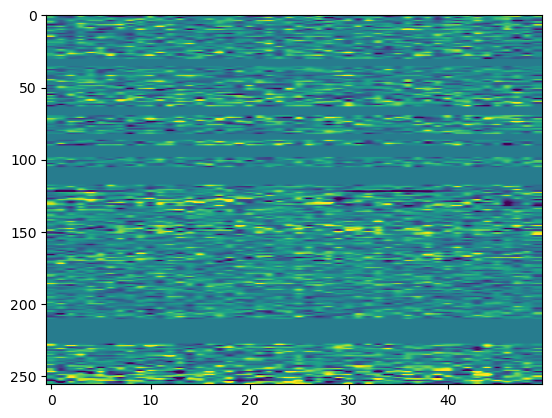

In [14]:
n=9
vmin = np.nanpercentile(padded_wfalls[n], 1)
vmax = np.nanpercentile(padded_wfalls[n], 99)
plt.imshow(padded_wfalls[n],aspect='auto',vmin=vmin,vmax=vmax)

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

n_components = 2 # number of latent dimensions

# padded_wfalls=np.array(padded_wfalls)
dims = (1024,100,1)

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [21]:
padded_wfalls=np.array(padded_wfalls).reshape((padded_wfalls.shape[0], -1))
# padded_wfalls=np.transpose(padded_wfalls,(1,2,0))
padded_wfalls.shape

(583, 102400)

In [3]:
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP(dims=dims)

In [ ]:
embedder.fit(padded_wfalls)

Epoch 1/10
